# MQ-7

## Ro calculation

### Specifications

#### Standard Work Condition

    Vc    (Circuit Voltage)        :  5v +/- 0.1
    VH(h) (Heating Voltage - high) :  5v +/- 0.1
    VH(l) (Heating Voltage - low)  :  1.4v +/- 0.1
    RL    (Load Resistance)        :  can adjust
    RH    (Heater Resistance)      :  33 Ohm +/- 5%
    TH(H) (Heating time (high)     :  60 +/- 1 seconds
    TH(L) (Heating time (low)      :  90 +/- 1 seconds
    PH    (Heating consumption)    :  about 350 mW
    

#### Sensitivity Characteristic:

    Rs (Sensing Resistance)    : 2kOhm  -  20kOhm (100ppm Carbon Monoxide)
    Preheat Time               : No less than 48 hours
    
    Detecting range:
        Carbon Monoxide:  20ppm  - 2000ppm 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
## Gas concentration values referenced in the datasheet
POINTS = {
     # Carbon Monoxide
    'co' : {
        'p1' : {'x': 50,   'y':1.605},
        'p2' : {'x': 100,  'y':1.000},
        'p3' : {'x': 400,  'y':0.381},
        'p4' : {'x': 1000, 'y':0.217},
        'p5' : {'x': 4000, 'y':0.090}
    },

    # Hydrogen
    'h2' : {
        'p1' : {'x': 50,   'y':1.278},
        'p2' : {'x': 100,  'y':0.792},
        'p3' : {'x': 400,  'y':0.276},
        'p4' : {'x': 1000, 'y':0.141},
        'p5' : {'x': 4000, 'y':0.052}
    },

    # Liquefied Petroleum Gas
    'lpg' : {
        'p1' : {'x': 50,   'y':9.005},
        'p2' : {'x': 100,  'y':7.989},
        'p3' : {'x': 400,  'y':6.675},
        'p4' : {'x': 1000, 'y':5.993},
        'p5' : {'x': 4000, 'y':4.948}
    },

    # Methane
    'ch4' : {
        'p1' : {'x': 50,   'y':13.859},
        'p2' : {'x': 100,  'y':12.745},
        'p3' : {'x': 400,  'y':11.720},
        'p4' : {'x': 1000, 'y':11.039},
        'p5' : {'x': 4000, 'y':9.005}
    },

    'alcohol' : {
        'p1' : {'x': 50,   'y':16.194},
        'p2' : {'x': 100,  'y':14.715},
        'p3' : {'x': 400,  'y':13.054},
        'p4' : {'x': 1000, 'y':12.745},
        'p5' : {'x': 4000, 'y':12.004}
    },    
}


AIR = 25.836

GASES = ['co', 'h2', 'lpg', 'ch4', 'alcohol']

In [3]:
# RS value calculation
Rs    = lambda Vcc, Vrl, RL : ((Vcc * RL) / Vrl) - RL

# R0 value calculation
R0    = lambda Rs, air : Rs / air

# RS/Ro value calculation (ratio)
Ratio = lambda Rs, R0: Rs / R0

# log(y) = m.log(x) + b
# m
M     = lambda p1, p2 : (math.log10( p2['y'] / p1['y'] )) / (math.log10(p2['x']/p1['x']))
# b
B     = lambda p, m : math.log10(p['y']) - (m * math.log10(p['x']))

# PPM value calculation 
PPM   = lambda  y, m, b: 10 ** ((math.log10(y) - b) / m)

In [4]:
## Calculate the points to be used for the calculation of _m_ and _b_ according to the _ratio_ value 
def getPoints(racio, values):
    size = len(values)
    for idx in range(size - 1):
        if racio >= values[idx]['y']:
            if idx == 0:
                return (values[0], values[1])
            return(values[idx - 1], values[idx])
    return(values[size - 2], values[size - 1])

In [5]:
pList = {}
for gas in GASES:
    pList[gas] = list(POINTS[gas].values())

In [6]:
col_list = ["date", "mq7_1", "mq7_2"]
df = pd.read_csv('RoomInNormalDay_Jun[14 - 15].csv', usecols=col_list)

df['date']= pd.to_datetime(df['date'])

mq7_1 = df[["date","mq7_1"]]
mq7_2 = df[["date","mq7_2"]]

### Ro values to be considered

- __Sensor 1__: 12.51 kOhms
- __Sensor 2__: 5.66 kOhms 

In [7]:
# MQ 7 - sensor 1
sensor1 = {}
sensor1['Vcc'] = 5      #volts
sensor1['RL']  = 10     #kOhms
sensor1['AIR'] = AIR   
sensor1['Ro']  = 12.51  #kOhms

# MQ 7 - sensor 2
sensor2 = {}
sensor2['Vcc'] = 5      #volts
sensor2['RL']  = 10     #kOhms
sensor2['AIR'] = AIR   
sensor2['Ro']  = 5.66   #kOhms

In [8]:
# Min; Mean; Median; Quantile [0.25, 0.5, 0.75]; Max

Vrl = [
    mq7_1['mq7_1'].min(),
    mq7_1['mq7_1'].mean(), 
    mq7_1['mq7_1'].quantile(0.25),
    mq7_1['mq7_1'].quantile(0.5),
    mq7_1['mq7_1'].quantile(0.75),
    mq7_1['mq7_1'].max()]

sensor1['Rs'] = [Rs(sensor1['Vcc'] , v, sensor1['RL'] ) for v in Vrl]
sensor1['Ratio'] = [Ratio(rs, sensor1['Ro']) for rs in sensor1['Rs']]

ppm1 = {}
for gas in GASES:
    ppm1[gas] = []

for r in sensor1['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm1[gas].append(PPM(r, m, b))

In [9]:
# Min; Mean; Median; Quantile [0.25, 0.5, 0.75]; Max

Vrl = [
    mq7_2['mq7_2'].min(),
    mq7_2['mq7_2'].mean(), 
    mq7_2['mq7_2'].quantile(0.25),
    mq7_2['mq7_2'].quantile(0.5),
    mq7_2['mq7_2'].quantile(0.75),
    mq7_2['mq7_2'].max()]

sensor2['Rs'] = [Rs(sensor2['Vcc'] , v, sensor2['RL'] ) for v in Vrl]
sensor2['Ratio'] = [Ratio(rs, sensor2['Ro']) for rs in sensor2['Rs']]

ppm2 = {}
for gas in GASES:
    ppm2[gas] = []

for r in sensor2['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm2[gas].append(PPM(r, m, b))

In [10]:
print(f"Period in which the readings were carried out: {mq7_1['date'].min()} - {mq7_1['date'].max()} \n")

print("Sensor 1")


print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
       .format('', 'Min', 'Mean', '1Q', '2Q', '3Q', 'Max'))

print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
       .format('Rs/Ro', 
               round(sensor1['Ratio'][0],3),
               round(sensor1['Ratio'][1],3),
               round(sensor1['Ratio'][2],3),
               round(sensor1['Ratio'][3],3),
               round(sensor1['Ratio'][4],3),
               round(sensor1['Ratio'][5],3)))

for gas in GASES:
    print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
           .format(gas.upper(), 
                   round(ppm1[gas][0],3),
                   round(ppm1[gas][1],3),
                   round(ppm1[gas][2],3),
                   round(ppm1[gas][3],3),
                   round(ppm1[gas][4],3),
                   round(ppm1[gas][5],3)))
    
print("-"*(12*7))
    
print("Sensor 2")

print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
       .format('', 'Min', 'Mean', '1Q', '2Q', '3Q', 'Max'))

print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
       .format('Rs/Ro', 
               round(sensor2['Ratio'][0],3),
               round(sensor2['Ratio'][1],3),
               round(sensor2['Ratio'][2],3),
               round(sensor2['Ratio'][3],3),
               round(sensor2['Ratio'][4],3),
               round(sensor2['Ratio'][5],3)))

for gas in GASES:
    print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
           .format(gas.upper(), 
                   round(ppm2[gas][0],3),
                   round(ppm2[gas][1],3),
                   round(ppm2[gas][2],3),
                   round(ppm2[gas][3],3),
                   round(ppm2[gas][4],3),
                   round(ppm2[gas][5],3)))

Period in which the readings were carried out: 2022-06-14 09:56:00 - 2022-06-15 16:23:00 

Sensor 1
             Min          Mean         1Q           2Q           3Q           Max         
Rs/Ro        27.749       20.901       21.405       20.236       20.236       15.854      
CO           0.768        1.164        1.124        1.22         1.22         1.745       
H2           0.579        0.873        0.843        0.915        0.915        1.302       
LPG          0.074        0.382        0.332        0.46         0.46         1.891       
CH4          0.16         1.671        1.372        2.183        2.183        16.438      
ALCOHOL      1.014        7.888        6.638        9.966        9.966        58.3        
------------------------------------------------------------------------------------
Sensor 2
             Min          Mean         1Q           2Q           3Q           Max         
Rs/Ro        26.73        24.974       25.839       25.003       25.003       

In [11]:
font = {
    'family': 'serif',
    'color':  'tab:red',
    'weight': 'normal',
    'size': 14
}

font_title = {
    'family': 'serif',
    'color':  'tab:blue',
    'weight': 'normal',
    'size': 16,
}

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray','tab:olive','tab:cyan']

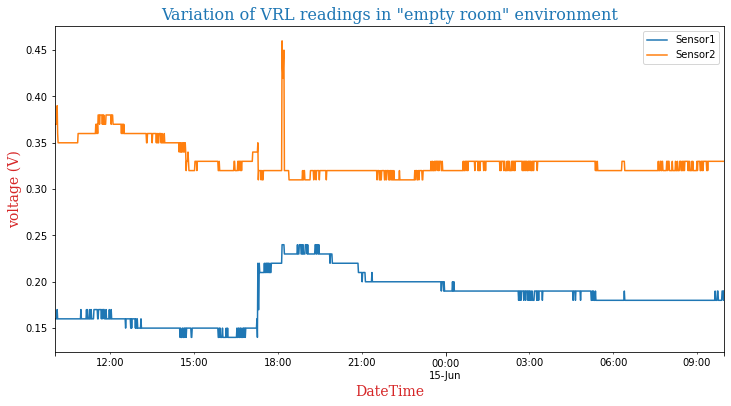

In [12]:
fdf = df[(df['date'] > '6/14/22 10:00 AM') & (df['date'] < '6/15/22 10:00 AM')]

ax = fdf.plot(x='date', y=["mq7_1","mq7_2"], 
              kind="line", figsize=(12, 6))

plt.title('Variation of VRL readings in "empty room" environment', fontdict=font_title)
plt.xlabel('DateTime',    fontdict=font)
plt.ylabel('voltage (V)', fontdict=font)
plt.legend(['Sensor1', 'Sensor2'], loc='best')


plt.show()

In [13]:
# MQ 7 Sensor1

sensor1['Rs'] = [Rs(sensor1['Vcc'] , v, sensor1['RL'] ) for v in mq7_1["mq7_1"]]
sensor1['Ratio'] = [Ratio(rs, sensor1['Ro']) for rs in sensor1['Rs']]

ppm1 = {}
for gas in GASES:
    ppm1[gas] = []
    
for r in sensor1['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm1[gas].append(PPM(r, m, b))

for gas in GASES:
    mq7_1[gas] = ppm1[gas]

In [14]:
# MQ 7 Sensor 2

sensor2['Rs'] = [Rs(sensor2['Vcc'] , v, sensor2['RL'] ) for v in mq7_2["mq7_2"]]
sensor2['Ratio'] = [Ratio(rs, sensor2['Ro']) for rs in sensor2['Rs']]
  
ppm2 = {}
for gas in GASES:
    ppm2[gas] = []
    
for r in sensor2['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm2[gas].append(PPM(r, m, b))

for gas in GASES:
    mq7_2[gas] = ppm2[gas]

In [15]:
mq7_1.describe()

,mq7_1,co,h2,lpg,ch4,alcohol
count,1828.000000,1828.000000,1828.000000,1828.000000,1828.000000,1828.000000
mean,0.184179,1.171001,0.877872,0.471027,2.605466,11.048813
std,0.022161,0.213809,0.158499,0.357012,2.995791,10.835635
min,0.140000,0.768376,0.578869,0.073961,0.160268,1.014317
25%,0.180000,1.123915,0.843116,0.332455,1.372032,6.638478
50%,0.190000,1.220270,0.914553,0.460163,2.183018,9.966384
75%,0.190000,1.220270,0.914553,0.460163,2.183018,9.966384
max,0.240000,1.744795,1.302435,1.890721,16.437643,58.299876


In [16]:
mq7_2.describe()

,mq7_2,co,h2,lpg,ch4,alcohol
count,1828.00000,1828.000000,1828.000000,1828.000000,1828.000000,1828.000000
mean,0.33035,0.897646,0.675057,0.142088,0.424357,2.340292
std,0.01576,0.069238,0.051442,0.058846,0.333675,1.413765
min,0.31000,0.811689,0.611123,0.091860,0.218432,1.329921
25%,0.32000,0.852999,0.641868,0.111771,0.289094,1.699517
50%,0.33000,0.895134,0.673210,0.135234,0.379549,2.156596
75%,0.33000,0.895134,0.673210,0.135234,0.379549,2.156596
max,0.46000,1.517661,1.134660,1.089558,7.479188,29.271966


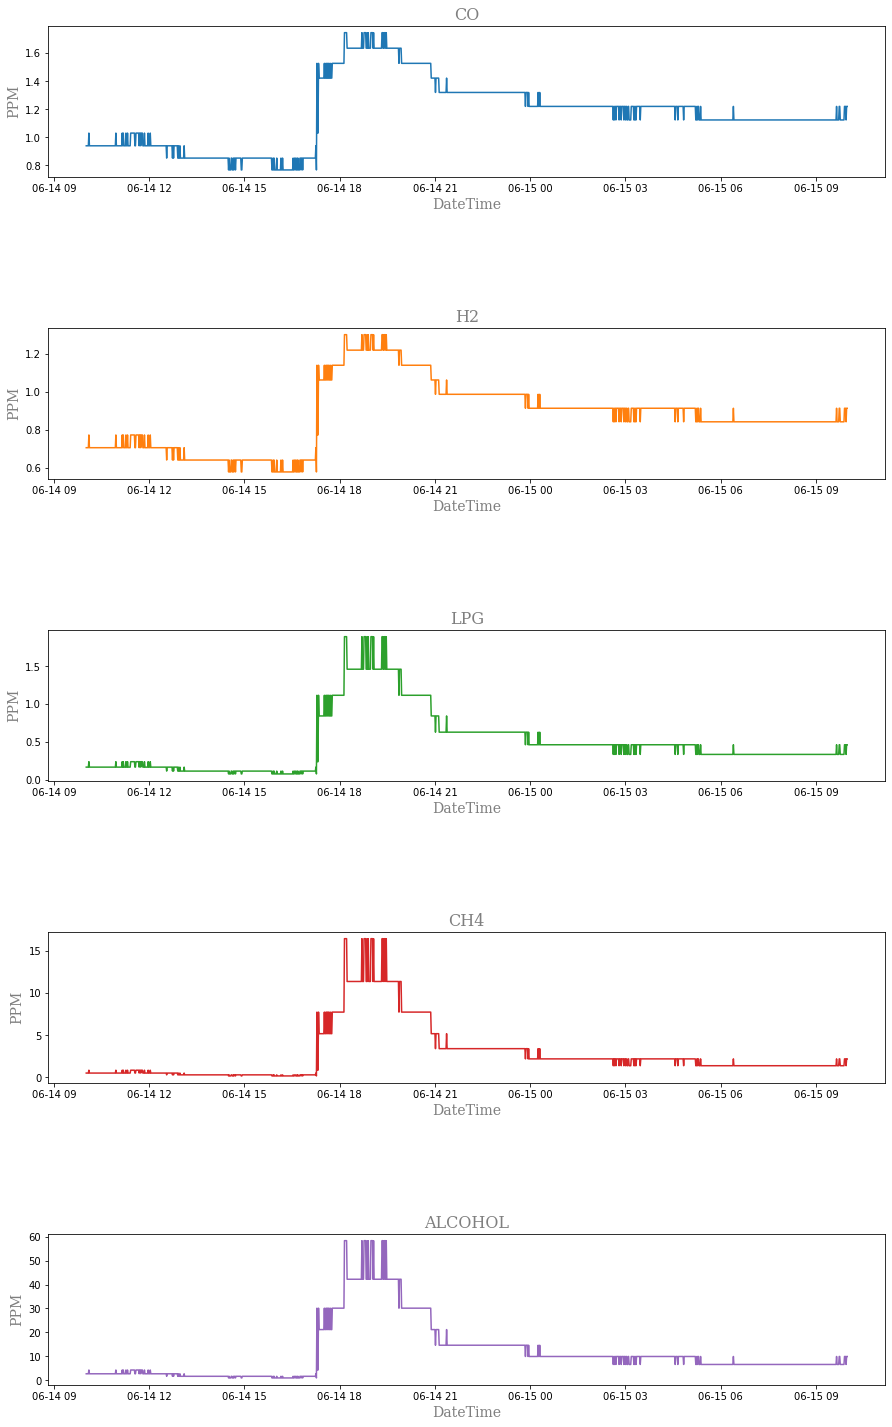

In [17]:
# Time Interval:
#           min: 2022-06-14 09:56:00
#           max: 2022-06-15 16:23:00 
  
fmq = mq7_1[(mq7_1['date'] > '6/14/22 10:00 AM') & (mq7_1['date'] < '6/15/22 010:00 AM')]

plt.figure(figsize=(15, 25))
plt.subplots_adjust(hspace = 1)

for idx in range(len(GASES)):
    plt.subplot(len(GASES) * 100 + 11 + idx)
    plt.plot(fmq['date']         , fmq[GASES[idx]],        color=colors[idx])
    plt.xlabel('DateTime'        , fontdict=font,          color='tab:gray')
    plt.ylabel('PPM'             , fontdict=font,          color='tab:gray')
    plt.title(GASES[idx].upper() , fontdict=font_title,    color='tab:gray')
    


plt.show()

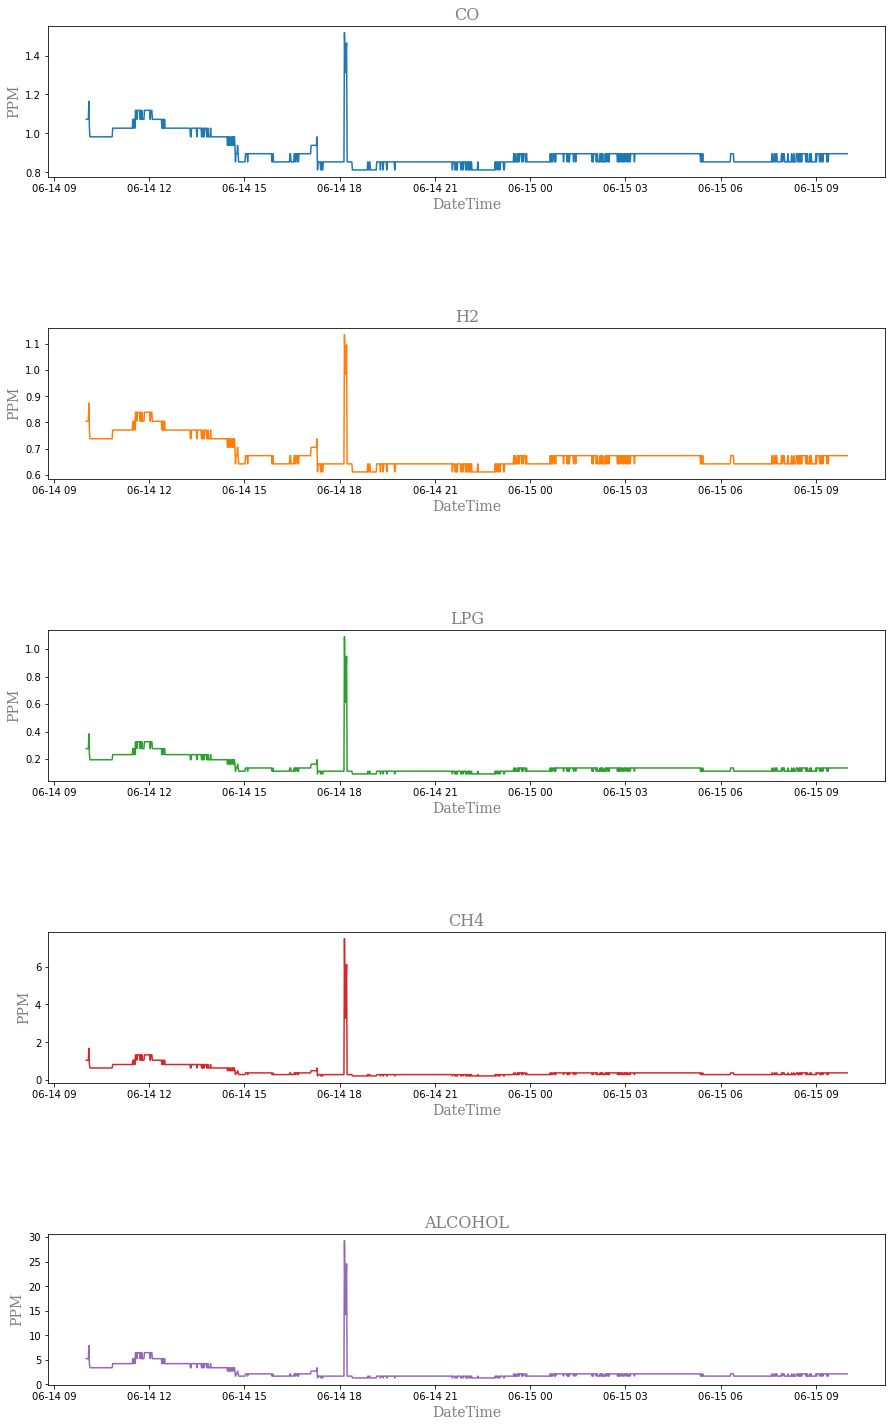

In [18]:
# Time Interval:
#           min: 2022-06-14 09:56:00
#           max: 2022-06-15 16:23:00 
  
fmq = mq7_2[(mq7_2['date'] > '6/14/22 10:00 AM') & (mq7_2['date'] < '6/15/22 010:00 AM')]

plt.figure(figsize=(15, 25))
plt.subplots_adjust(hspace = 1)

for idx in range(len(GASES)):
    plt.subplot(len(GASES) * 100 + 11 + idx)
    plt.plot(fmq['date']         , fmq[GASES[idx]],        color=colors[idx])
    plt.xlabel('DateTime'        , fontdict=font,          color='tab:gray')
    plt.ylabel('PPM'             , fontdict=font,          color='tab:gray')
    plt.title(GASES[idx].upper() , fontdict=font_title,    color='tab:gray')
    


plt.show()

In [19]:
# Save in excel file
mq7_1.to_csv('mq7_1.csv')
mq7_2.to_csv('mq7_2.csv')